## Introduction 
Autoencoder are special type of deep learning architecture that consist of two networks encoder and decoder.
The encoder, through a series of CNN and downsampling, learns a reduced dimensional representation of the input data while decoder  through the use of CNN and upsampling, attempts to regenerate the data from the these representations. A well-trained decoder is able to regenerated data that is identical or as close as possible to the original input data.
Autoencoder are generally used for anamoly detection, denoising image, colorizing the images. Here, i am going to colorize the landscape images using autoencoder.

<img src = 'https://miro.medium.com/max/600/1*nqzWupxC60iAH2dYrFT78Q.png' >

## Image Colorization
Image colorization using different softwares require large amount of human effort, time and skill.But special type of deep learning architecture called autoencoder has made this task quiet easy. Automatic image colorization often involves the use of a class of convolutional neural networks (CNN) called autoencoders. These neural networks are able to distill the salient features of an image, and then regenerate the image based on these learned features. 

![](https://i.imgur.com/LYSAOD3.png)


## Import necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

### Getting landscape image data,resizing them and appending in array
To get the image in sorted order i have defined the function sorted_alphanumeric. Here, I have used open cv library to read and resize images. Finally images are normalized and are converted to array and are appended in empty list

In [39]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '/home/tsm62803/my_code/Dataset/landscape'
files = os.listdir(path)
files = sorted_alphanumeric(files)
count = 0
for i in tqdm(files):
    if count == 20000:
        break
    else:    
        count += 1 
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '/home/tsm62803/my_code/Dataset/landscape'
files = os.listdir(path)
files = sorted_alphanumeric(files)
count = 0
for i in tqdm(files):
     if count == 20000:
        break
     else: 
        count += 1
        img = cv2.imread(path + '/'+i,1)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
#         noise_factor = 0.3 # add noise
#         img = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape) # add noise
#         img = np.clip(img, 0., 1.) # add noise
        gray_img.append(img_to_array(img))
         

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4319/4319 [00:45<00:00, 94.20it/s]


### Plotting Color image and it's corresponding grayscale image

In [43]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale,cmap='gray') # for grayscale images
    #plt.imshow(grayscale) # for color images
    plt.show()

**Plotting image pair**

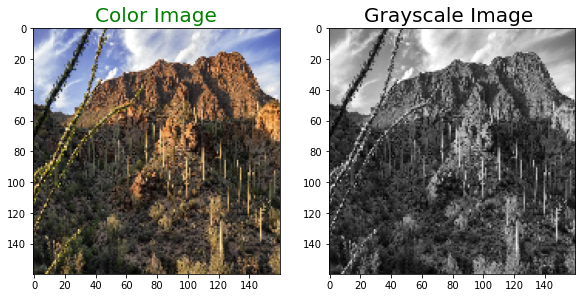

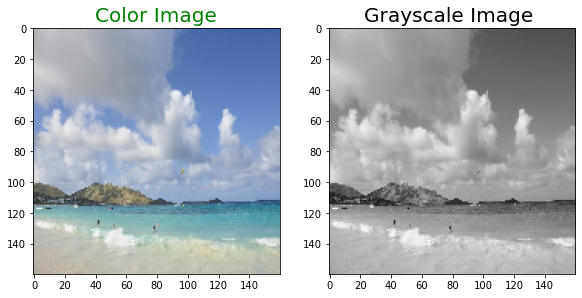

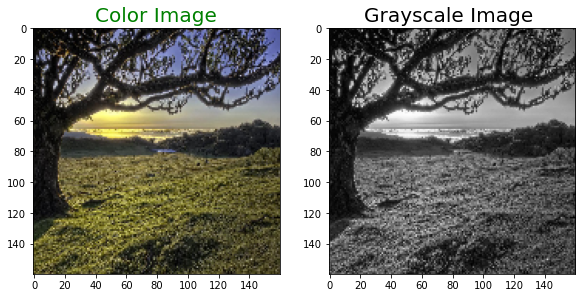

In [44]:
for i in range(500,503):
     plot_images(color_img[i],gray_img[i])

### Slicing and reshaping
Out of 5000 images I have sliced them to two part. train images consist 4000 images  while test images contains 1000 images.
After slicing the image array, I reshaped them so that images can be fed directly into our encoder network

In [45]:
train_gray_image = gray_img[:4000 ]
train_color_image = color_img[:4000 ]

test_gray_image = gray_img[4000: ]
test_color_image = color_img[4000: ]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,1))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,1))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (4000, 160, 160, 3)
Test color image shape (319, 160, 160, 3)


## Definie the model

In [2]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample


In [3]:
def model():
    #inputs = layers.Input(shape= [160,160,3]) # for color images
    inputs = layers.Input(shape= [160,160,3]) # for colorization
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [4]:
# train a new model
model = model()

# load checkpoint
# checkpoint_path = "/home/tsm62803/my_code/final project checkpoints/anime/de-noise" + "/cp.ckpt"
# model.load_weights(checkpoint_path)

#model.summary()

2022-01-03 16:00:22.119953: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-03 16:00:26.297809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30997 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0001:00:00.0, compute capability: 7.0
2022-01-03 16:00:26.299755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30997 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0002:00:00.0, compute capability: 7.0
2022-01-03 16:00:26.301570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:

In [49]:
checkpoint_path = "/home/tsm62803/my_code/final project checkpoints/landscape" + "/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


### Fitting our model

In [51]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs = 50, batch_size = 256,verbose = 1, shuffle=True, callbacks=[cp_callback])

2022-01-03 15:07:49.239186: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 390.62MiB (rounded to 409600000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-01-03 15:07:49.239240: I tensorflow/core/common_runtime/bfc_allocator.cc:1004] BFCAllocator dump for GPU_0_bfc
2022-01-03 15:07:49.239251: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (256): 	Total Chunks: 35, Chunks in use: 35. 8.8KiB allocated for chunks. 8.8KiB in use in bin. 568B client-requested in use in bin.
2022-01-03 15:07:49.239258: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (512): 	Total Chunks: 8, Chunks in use: 8. 4.0KiB allocated for chunks. 4.0KiB in use in bin. 4.0KiB client-requested in use in bin.
2022-01-03 15:07:49.239265: I tens

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
model.evaluate(test_gray_image,test_color_image, verbose = 1)

In [ ]:
import gc

gc.collect()

# plotting colorized image along with grayscale and color image

In [73]:

#load checkpoint
checkpoint_path = "/home/tsm62803/my_code/final project checkpoints/anime/de-noise 500" + "/cp.ckpt"
model.load_weights(checkpoint_path)

# defining function to plot images pair
def plot_images(color,grayscale,predicted, training_or_testing):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Original Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale, cmap='gray')
    plt.subplot(1,3,3)
    #plt.title('colorized Image ', color = 'Red', fontsize = 20)
    plt.title('De-noised Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
    if training_or_testing == 0:
        plt.savefig("/home/tsm62803/my_code/Introduction-to-Data-Science/Final Project/results/de-noise/500 epoch/training set/" + str(count), bbox_inches='tight')
    else:
        plt.savefig("/home/tsm62803/my_code/Introduction-to-Data-Science/Final Project/results/de-noise/500 epoch/testing set/" + str(count), bbox_inches='tight')
    plt.show()

print("Training set performance")
for i in range(1050,1060):
    count = i
    predicted = np.clip(model.predict(train_gray_image[i].reshape(1,SIZE, SIZE,1)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(train_color_image[i],train_gray_image[i],predicted, 0)

print("Testing set performance")
for i in range(1000,1010):
    count = i
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,1)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted, 1)

 

ValueError: Shapes (2, 2, 4, 3) and (2, 2, 6, 3) are incompatible

In [5]:

#load checkpoint
checkpoint_path = "/home/tsm62803/my_code/final project checkpoints/anime/de-noise 500" + "/cp.ckpt"
model.load_weights(checkpoint_path)

# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Original Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.axis("off")
    plt.subplot(1,3,2)
#     plt.title('Grayscale Image ', color = 'black', fontsize = 20)
#     plt.imshow(grayscale, cmap='gray')
#     #plt.axis("off")
#     plt.subplot(1,3,3)
    plt.title('Colorized Image ', color = 'Red', fontsize = 20)
    #plt.title('De-noised Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
    plt.axis("off")
    plt.show()
    
SIZE = 160
color_img = []
path = "/home/tsm62803/my_code/Dataset/animefaces256cleaner/18556684_result.jpg"
img = cv2.imread(path)
# open cv reads images in BGR format so we have to convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#resizing image
img = cv2.resize(img, (SIZE, SIZE))
img = img.astype('float32') / 255.0
color_img.append(img_to_array(img))


gray_img = []
 
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#resizing image
img = cv2.resize(img, (SIZE, SIZE))
img = img.astype('float32') / 255.0
gray_img.append(img_to_array(img))
         

predicted = np.clip(model.predict(gray_img[0].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
plot_images(color_img[0],gray_img[0],predicted)

ValueError: cannot reshape array of size 25600 into shape (1,160,160,3)

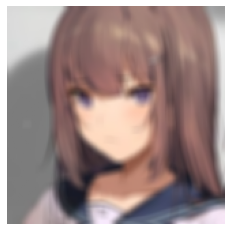

In [20]:
gray_img = []
 
img = cv2.imread("/home/tsm62803/my_code/Introduction-to-Data-Science/10090845_result.jpg")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ksize = (10, 10)
img = cv2.blur(img, ksize) 
#resizing image
img = cv2.resize(img, (SIZE, SIZE))
img = img.astype('float32') / 255.0
gray_img.append(img_to_array(img))

# defining function to plot images pair
def plot_images(grayscale):
    #plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale,cmap='gray') # for grayscale images
    plt.axis('off')
    plt.show()

plot_images(gray_img[0])